In [6]:
import phaseco as pc
from scipy.signal import get_window
import numpy as np
import matplotlib.pyplot as plt

In [14]:


verbose=False
target_xi_s = 0.01
target_esc = 0.1
rho_step = 0.001
win_type = 'flattop'
fss = [44100, 48000]


# Define func for test
get_esc_rho = lambda N_rho_steps: pc.get_exp_spur_coh(tau, xi, pc.get_win({'method':'rho', 'rho':N_rho_steps*rho_step, 'win_type':win_type}, xi=xi, tau=tau)[0])


print(f"Finding ideal rho so that the expected spurious coherence at {target_xi_s} is {target_esc}")
for fs in fss:
    # Get xi and tau
    match fs:
        case 44100:
            tau = 3285
        case 48000:
            tau = 3576
        case _:
            raise ValueError("Invalid fs!")
    xi = int(round(target_xi_s * fs))
    print(f"fs = {fs}")

    
    esc = 0
    lo = 10
    hi = 20
    # Search for upper bound
    print("Initializing exponential search for upper bound") if verbose else None
    print(f"Lower bound is rho={lo*rho_step}") if verbose else None
    print(f"Testing {hi*rho_step} as upper bound:") if verbose else None
    
    while get_esc_rho(hi) < target_esc:
        lo = hi
        hi *= 2
        print(f"Testing {hi*rho_step}") if verbose else None
    print(f"Found upper bound: {hi*rho_step}") if verbose else None
    print(f"Initializing binary search") if verbose else None

    # Binary search between lo and hi until they are neighbors
    while hi - lo > 1:
        mid = (lo + hi + 1) // 2
        print(f"[{lo*rho_step}, {hi*rho_step}] --- testing {mid*rho_step}") if verbose else None
        mid_esc = get_esc_rho(mid)
        if mid_esc < target_esc:
            lo = mid
        else:
            hi = mid
    print(f"Now we're down to [{lo*rho_step}, {hi*rho_step}]") if verbose else None
    lo_esc = get_esc_rho(lo)
    hi_esc = get_esc_rho(hi)
    # Check which is closer
    if np.abs(hi_esc - target_esc) < np.abs(lo_esc - target_esc):
        rho = hi*rho_step
        final_esc = hi_esc
    else:
        rho = lo*rho_step
        final_esc = lo_esc

    print(f"Final answer: {rho} for ESC={final_esc}") 

Finding ideal rho so that the expected spurious coherence at 0.01 is 0.1
fs = 44100
Final answer: 0.866 for ESC=0.10019405440158198
fs = 48000
Final answer: 0.866 for ESC=0.10020726238453737


In [16]:


"Verify through white noise waveform"
rng = np.random.default_rng()
fs = 44100
wf_len_s = 60
N = fs * wf_len_s
wf = rng.normal(loc=0, scale=1, size=N)
# Coherence parameters
rho = 0.866
win_type = 'flattop'
tau = 3285
hop = 0.1
xis = {'xi_min_s':0.001, 'delta_xi_s':0.001, 'xi_max_s':0.01}
win_meth = {'method':'rho', 'win_type':win_type, 'rho':rho}
# win_meth = {'method':'zeta', 'win_type':win_type, 'zeta':target_esc}

xis_s, f, cgram = pc.get_colossogram(wf, fs, tau=tau, xis=xis, hop=hop, win_meth=win_meth, pw=False)
_, _, cgram_pw = pc.get_colossogram(wf, fs, tau=tau, xis=xis, hop=hop, win_meth=win_meth, pw=True)

mean = np.mean(cgram, axis=-1)
mean_pw = np.mean(cgram_pw, axis=-1)




  

tau=3285 is not a power of two, so rounding up to 4096 for nfft (for FFT gains)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


tau=3285 is not a power of two, so rounding up to 4096 for nfft (for FFT gains)


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


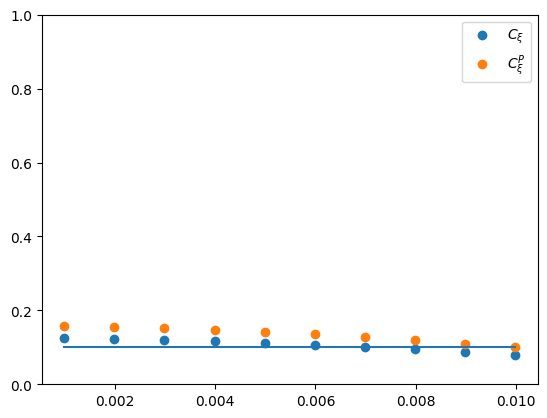

In [17]:
plt.figure()
plt.scatter(xis_s, mean, label=r'$C_\xi$')
plt.scatter(xis_s, mean_pw, label=r'$C_\xi^P$')
plt.plot(xis_s, target_esc*np.ones(len(xis_s)))
plt.ylim(0, 1)
plt.legend()
plt.show()